<a href="https://colab.research.google.com/github/AnnaMalmgren/deep_learning_birdsong_classification/blob/main/project_preprocess_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extration

### Anna Malmgren 
This is a colab file for the final project in the course Deep Learning - metoder och tillämpningar, held by Umeå University. 

**Other colab files for the project:**   
[Data Exploration](https://colab.research.google.com/drive/1XhDb5psoArmqCB3sgI4TEZuG6NXtI3GU?usp=sharing)  

[Training and Evaluation](https://colab.research.google.com/drive/14B5j_LmViakBlDBIoNYqXEJjro5UPPnl?usp=sharing)

## Install and Import dependencies

dataset from: [birdsongs-from-europe](https://www.kaggle.com/datasets/monogenea/birdsongs-from-europe)


In [ ]:
# install kaggle to be able to download dataset 
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# upload kaggle.json so that data can be downloaded through Kaggle's API

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
# Import dependencies

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Dependencies for extract features from the audio files
import librosa
import librosa.display
from scipy.signal import butter, lfilter
from skimage.restoration import denoise_wavelet 
from PIL import Image 

# Dependencies for vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dependencies for file handling
from pathlib import Path
import os
import glob


import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download and unzip the birdsongs-from-europe dataset from kaggle

!kaggle datasets download -d monogenea/birdsongs-from-europe --unzip

100% 7.45G/7.46G [01:00<00:00, 141MB/s]
100% 7.46G/7.46G [01:00<00:00, 132MB/s]


## Class Definitaions

Defining classes for load files, saving files, creating mel spectrograms and generating the datasets (i.e., training set, validation set, test set). 

The mel spectrograms are saved as jpg images in "content/dataset/melspectrograms". The mel spectrogram images is further divided into folders by the bird species, for example all mel spectrogram images for Sonus naturlis is located in "content/dataset/melspectrograms/Sonus naturlis/".

The images is divided into three sets and saved in a training csv file, validation csv file, and test csv file. Each csv file contains the file paths to their respective mel spectrogram images ('data_x') and the label for the image as a numeric representation ('data_y'). 

In [ ]:
# This cell contains the class FileLoader for loading needed files
# and FileSaver for saving create log-mel spectrogram images and csv files
# defining the different dataset splits. 

class FileLoader:
  """
  Class responsible for converting audio files from mp3 to wav, 
  fetching wanted labels, audio files or mel spectogram image files
  """
 
  mp3, wav = 'mp3', 'wav'
  df_path = 'Path'
  df_species = 'Species'
  
  def __init__(self, cwd='/content/mp3', metadata_path='/content/metadata.csv',):
    self._df = pd.read_csv(metadata_path)
    self._labels = self._df[self.df_species].unique()
    self._prepare_files(cwd)

  def get_audio_by_label(self, label):
    """
    Fetches all audio files for given label.

    Parameters:
    label: string defining what bird species to retreieve audio data for

    Returns:
    array containing the paths to the audio files for the given label.
    """ 
    return self._df.loc[self._df[self.df_species] == label, self.df_path].values
  
  def get_labels(self):
    """
    Returns all unique labels (bird species) in the dataset
    """
    return self._labels
  
  def get_melspectogram_paths(self, root, label):
    """
    Fetches all mel spectogram file paths for the given label

    Parameters: 
    root: string defining the root directory 
    label: string defining the wanted bird species

    Returns:
    array containing the file paths to a specific bird species all mel 
    spectograms. 
    """
    return glob.glob(f'{root}/{label}/**/*.jpg', recursive = True)

  def _prepare_files(self, dir):
    """
    Converts the mp3 files in the given dircetory to wav files, 
    and updates the file paths in the metadata file accordingly. 
    """
    self._suffix_to_wav(dir)
    self._df[self.df_path] = (self._df[self.df_path]
                                  .apply(lambda x: f'{dir}{x.replace(self.mp3, self.wav)[4:]}'))

  def _suffix_to_wav(self, directory):
    """
    Converts the mp3 files in the given dircetory to wav files

    Parameters:
    directory: string defining the directory containing the mp3 files.
    """
    for dir, _, files in os.walk(directory):
      for file in files:
        if (Path(file).suffix.lower()[1:] != self.wav): 
          original_path = os.path.join(dir, file)
          new_path = os.path.join(dir, Path(file).with_suffix('.' + self.wav))
          os.rename(original_path, new_path)


class FileSaver:
  """
  Class responsible for image files and creating directories
  """

  jpg = 'jpg'

  def __init__(self, root='/content/dataset'):
    self.root = root

  def save_img_files(self, file_paths, img_data, dir):
    """
    Saves all the given image data to the given directory, using the given 
    file paths. 

    Parameters:
    file_paths: array containing the paths to the original audio files
    img_data: 2d array, containing an array for each file path, which in turn 
              contains an array of image data.
    dir: string defining the what directory to save the image files in.  

    Returns: 
    the paths to the saved image files.
    """
    saved = []

    for index, file in enumerate(file_paths):
      i = 1
      for image in img_data[index]:
        file_name = self._get_img_name(file, i)
        saved.append(self.save_img_file(file_name, image, dir))
        i += 1

    return saved   
  
  def save_img_file(self, file_name, img_data, dir):
    """
    Saves a given image file to given path. 

    Parameters:
    file_name: string defining the name of the image file
    img_data: array containing the data to be converted into an image file
    dir: string defining the directory to save the image file into

    Returns: 
    the path for the saved image file as a string.
    """
    file_path = f'{self.root}/{dir}'
    self._create_dir(file_path)

    img = Image.fromarray(img_data).convert("L")

    save_path = os.path.join(file_path, file_name)

    if (os.path.exists(save_path)):
      os.remove(save_path)

    img.save(save_path)
    return save_path
  
  def _get_img_name(self, file_path, num):
    """
    Gets an image's file name from givenfile path. 

    Parameters: 
    file_path: string defining the file path for the original audio file
    num: integer to create different file names for windows of the same audio file

    Returns: 
    string defining the image file name
    """
    file_name = file_path.split('/')[-1] # get the file name from the path
    file_name =  file_name.split('.')[0] # get the file name without the suffix

    return f'{file_name}_{num}.{self.jpg}'

  def save_csv_file(self, file_name, data_x, data_y):
    """
    Saves given data as an csv file

    Parameters:
    file_name: string defining the name of the csv file to save
    data_x: array containing the data records (file paths to mel spectograms)
    data_y: array containing the labels 

    Returns: 
    string defining the path to the saved csv file. 
    """
    csv_path = os.path.join(self.root, f'{file_name}.csv')
    file_conent = pd.DataFrame({'data_x':data_x,'data_y':data_y})
    file_conent.to_csv(csv_path, index=False)
    return csv_path

  def _create_dir(self, path):
    """
    Checks if given path exists, if not the directory is created.

    Parameters:
    path: string defyning the path to the directory to create it not existing. 

    Returns: 
    Boolen, True if directory exists or is created, else False. 
    """
    try:
      if (not os.path.exists(path)):
        os.makedirs(path)
    except OSError as error:
      print(f'Directory {path} can not be created')
      return False

    return True


In [ ]:
# This cell contains the MelSpectrogram class, which filters and clips the audio 
# signals and generates normalized and scaled log-mel spectrorgams. It also 
# contains the DataGenerator class which uses the FileLoader class to load the
# audio for given labels, then uses the Melspectrogram class to generate images, 
# and the SaveFile class to save the images. The Datagenerator class also splits
# the dataset into training, validation, and test sets, and uses the SaveFiler to
# save the splits in three csv files. 

# and https://github.com/AdityaDutt/Bird-Song-Classification/blob/main/classify.py
# and https://github.com/ryanwongsa/kaggle-birdsong-recognition
# https://www.kaggle.com/code/virajkadam/birdclef-extracting-spectrograms

class MelSpectogram():
  """
  Class for generating mel spectograms from audio files. 
  """
  def __init__(self, config):
    self._conf = config
    self._clip_length = config.get('duration') * config.get('sample_rate')
    self._hop_length = (self._clip_length // (config.get('n_mels') - 1))
    self._nyq = config.get('sample_rate') // 2
    self._window = 'hann'

  
  def get_windowed_melspectograms(self, waveform):
    """
    Split given waveform into windows and creates mel spectograms for each window. 

    Parameters:
    waveform: array containing the signal (waveform) data
    return_dB: Boolean to define if mel spectogram should be expressed in dB.
               Default is True. 
    bandpass_filter: Boolean to define if bandpass filter should be used. 
                     Default is True. 
    
    Returns: 
    array of the mel spectograms. 
    """
    mels = []

    waveform = self.butter_bandpass_filter(waveform)
    waveform = librosa.effects.preemphasis(y=waveform)


    for step in range(0, len(waveform), self._clip_length):

      curr_window = waveform[step:step + self._clip_length]

      if len(curr_window) < self._clip_length: 
        curr_window = self._padd_window(curr_window)

      S = self.get_mel_spectogram(curr_window)
      mels.append(S)

    return mels
  
  def get_mel_spectogram(self, waveform):
    """
    Creating, normalizes, and denoising  a mel spectogram from given waveform 
    using Librosa. 

    Parameters:
    waveform: array representing the waveform to create mel spectogram of.
    return_dB: Boolean to define if mel spectogram should be expressed in dB.
               Default is True. 
    
    Returns: 
    array of the created mel spectogram
    """
    S = librosa.feature.melspectrogram(waveform,
                                       sr=self._conf.get('sample_rate'),
                                       n_mels=self._conf.get('n_mels'),
                                       hop_length=self._hop_length,
                                       win_length=self._conf.get('win_length'),
                                       n_fft=self._conf.get('n_fft'),
                                       fmin=self._conf.get('fmin'),
                                       fmax=self._conf.get('fmax'),
                                       window=self._window)
    
    S_dB = librosa.power_to_db(np.abs(S), ref=np.max)
    return self._denoise_mel(S_dB)
  

  def _padd_window(self, window, mode='constant'):
    """
    Padds a given array to wanted length using numpy's pad method.

    Parameters:
    window: array to pad
    mode: string defining what numpy pad mode to use. Defaut is 'constant'.

    Return: 
    the padded array. 
    """
    padding_left = (self._clip_length - len(window)) // 2
    padding_right = self._clip_length - len(window) - padding_left 
    return np.pad(window, (padding_left, padding_right), mode)
  
  def _denoise_mel(self, data):
    """
    Uses skimage.restoration method denoise_wavelet to denoise mel spectogram

    Parameters:
    data: array representing the mel spectogram to denoise.
    
    Returns: 
    array of the denoised mel spectogram
    """
    norm = self._normalize_mel(data)
    return denoise_wavelet(norm)

  def _normalize_mel(self, mel, eps=1e-6):
    """
    Code from: https://medium.com/@hasithsura/audio-classification-d37a82d6715
    Parameters:
    mel: array of the mel spectogram data to be normalized 

    """
    norm = (mel - mel.mean()) / (mel.std() + eps)
    return 255.0 * (norm - norm.min()) / (norm.max() - norm.min())
  
  def butter_bandpass(self, order=5):
    """
    Uses scipy.signal's butter method to retrieve filter coefficients.

    Parameters: 
    order: integer defining the order of the filter (N in scipy.signal butter).
    
    Returns: 
    numpy array (numerator) and numpy array (denominator) 
    polynomials of the IIR filter.
    """
    low = self._conf.get('low_cut') / self._nyq
    high = self._conf.get('max_cut') / self._nyq
    return butter(order, [low, high], btype='band')

  def butter_bandpass_filter(self, data, order=5):
    """
    Uses scipy.signal's lfilter method to filter a given signal.

    Parameters: 
    data: array of the signal data to filter. 
    order: integer defining the order of the filter (N in scipy.signal butter).
    
    Returns: array of the output of the digital filter.
    """
    return lfilter(*self.butter_bandpass(order=order), data)
    
  
class DataGenerator:
  """
  Class for generating mel spectogram images, and creating needed datasets
  """
  def __init__(self, config, melspectogram, file_loader, file_saver):
    self._mono = config.get('mono')
    self._sr = config.get('sample_rate')
    self.mel = melspectogram
    self.files = file_loader
    self.saver = file_saver
  
  def load_audio(self, audio_file, res_type='kaiser_fast'):
    """
    Loads the given audio file using Librosa's load method. 

    Parameters:
    audio_file: string defining the path to the audio file to load. 
    res_type: string defining the res_type for Librosa's load method. 
              Default is 'kaiser_fast'.
    
    Returns: 
    numpy array of the audio time series. 
    """
    waveform, sr = librosa.load(audio_file,
                                mono=self._mono, 
                                sr=self._sr,
                                res_type=res_type)
    return waveform


  def create_melspectogram_images(self, labels):
    """
    Creates and saves mel spectogram images for given labels. A folder is created 
    for each label and the images are saved at: content/dataset/melspectogram/label

    Parameters:
    labels: array containing the bird species to use.
    """
    for label in labels:
      curr_files = self.files.get_audio_by_label(label)
      waveforms = [self.load_audio(file) for file in curr_files]
      features = [self.mel.get_windowed_melspectograms(y) for y in waveforms]
      mel_files = self.saver.save_img_files(curr_files, features, f'melspectograms/{label}')

  def generate_datasets(self, labels, val_size=0.2, test_size=0.1):
    """
    Creates csv files for the datasets containing file paths to the mel 
    spectorgam images (data_x) and their respective labels (data_y)

    Parameters:
    labels: array containing bird species to include in the dataset.
    val_size: split size for the validation data. Default 0.2
    test_size: split size for the test data. Default 0.1.

    Returns: 
    paths to the training-, validation, and test-metadata csv files. 
    """
    X, y = self._melspectogram_data(labels)

    train, val, test= self._split(X, y)

    train_metadata = self.saver.save_csv_file('train_data', *train)
    val_metadata = self.saver.save_csv_file('val_data', *val)
    test_metadata = self.saver.save_csv_file('test_data', *val)
 
    return train_metadata, val_metadata, test_metadata
  
  def _split(self, x_data, y_data, test_size=0.1, val_size=0.2):
    """
    Splits given data into training and test data using sklearn's train_test_split,
    then splits the training data again to seperate training and validation data. 

    Parameters: 
    x_data: array containing the mel spectogram file paths. 
    y_data: array containing each mel spectograms' bird species, converted to 
            numeric representation. 
    
    Returns: 
    tuples of X_data and y_data for training, validaiton, and testing. 
    """
    train_data, X_test, train_labels, y_test = train_test_split(x_data, 
                                                                y_data, 
                                                                test_size=test_size, 
                                                                random_state=42)      
    X_train, X_val, y_train, y_val = train_test_split(train_data, 
                                                      train_labels, 
                                                      test_size=val_size,
                                                      random_state=42) 
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)
  
 
  def _melspectogram_data(self, labels):
    """
    Gets all the mel spectogram file paths for given labels, together with the
    the mel spectograms' labels converted to numeric values using the indeces in ¨
    the given labels array. 

    Parameters: 
    lables: array with the wanted bird species. 

    Returns: 
    array (X) containing the mel spectogram file paths, 
    array (y) containing the labels converted to integer values. 
    """
    if (not os.path.exists(self.saver.root)):
      print('No mel spectogram images found.')
      return

    X, y = [], []
    for i, label in enumerate(labels): 
      mel_paths = self.files.get_melspectogram_paths(self.saver.root, 
                                                     f'melspectograms/{label}')
      numeric_labels = [i] * len(mel_paths)

      X += mel_paths
      y += numeric_labels
  
    return X, y

## Configurations And Dataset Generation

Following code cells defines the configurations for the audio features, i.e., the mel spectrograms. Then the needed class instances are created and the number of classes to include defined. Finally the mel spectrogram images are created and the datasets generated. 

In [ ]:
# Configurations for generating the mel spectograms
CONFIG = {
    'sample_rate': 32000,
    'n_mels': 128,
    'win_length': 2048,
    'n_fft': 2048,
    'duration': 3,
    'mono': True,
    'fmin': 100,
    'fmax': 15000,
    'low_cut': 500.0,
    'max_cut': 15000.0
}

# Class instances and number of labels (classes) to include 
# in the dataset
file_loader = FileLoader()
file_saver = FileSaver()
classes = file_loader.get_labels()[0:15]

data_generator = DataGenerator(CONFIG, 
                               MelSpectogram(CONFIG), 
                               file_loader, 
                               file_saver) 



print(f'Number of classes: {len(classes)}\n')
print('Classes includes the bird species: ')
print(*classes, sep='\n')

Number of classes: 15

Classes includes the bird species: 
Sonus naturalis
Fringilla coelebs
Parus major
Turdus merula
Turdus philomelos
Sylvia communis
Emberiza citrinella
Sylvia atricapilla
Emberiza calandra
Phylloscopus trochilus
Luscinia megarhynchos
Strix aluco
Phylloscopus collybita
Carduelis carduelis
Erithacus rubecula


In [ ]:
# create log-mel spectrograms
data_generator.create_melspectogram_images(classes)

# generate dataset csv files (train, validation, test)
train_csv, val_csv, test_csv = data_generator.generate_datasets(classes)


## Explore the generated dataset

Explore number of records in the datasets, as well as plotting the distribution of data records between the labels, and some mel spectrogram examples. 

Finally the mel spectrogram folder is zipped to be manually downloaded. The train_data.csv, val_data.csv, and test_data.csv files should be download as well. The zip file, and the csv files are then uploaded manually into the colab file that defines and trains the deep learning models: [Training and Evaluation Colab file](https://colab.research.google.com/drive/14B5j_LmViakBlDBIoNYqXEJjro5UPPnl?usp=sharing).

In [ ]:
# Print the number of records in each dataset

train_df = pd.read_csv(train_csv)
val_df= pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

print('Training\nrecords: ', len(train_df['data_x']), ' Labels: ', len(train_df['data_y']))
print('\nValidation\nrecords: ', len(val_df['data_x']), ' Labels: ', len(val_df['data_y']))
print('\nTest\nrecords: ', len(test_df['data_x']), ' Labels: ', len(test_df['data_y']))

Training
records:  29864  Labels:  29864

Validation
records:  7467  Labels:  7467

Test
records:  7467  Labels:  7467


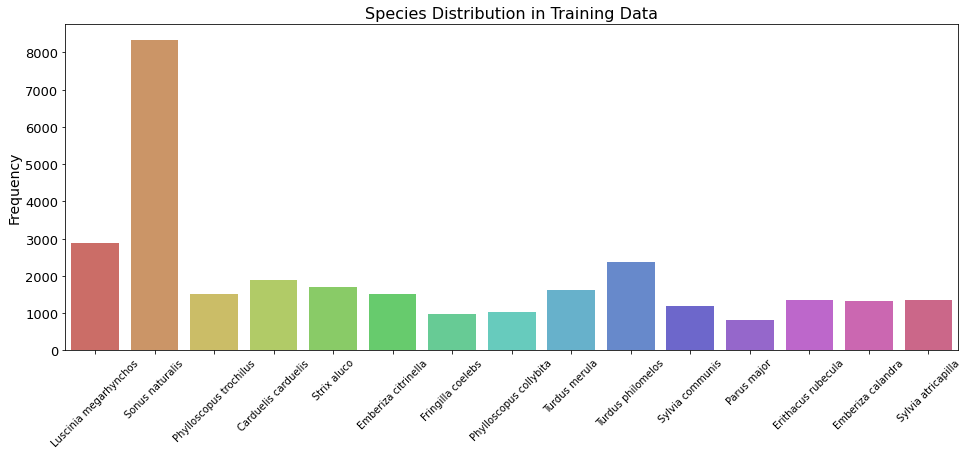

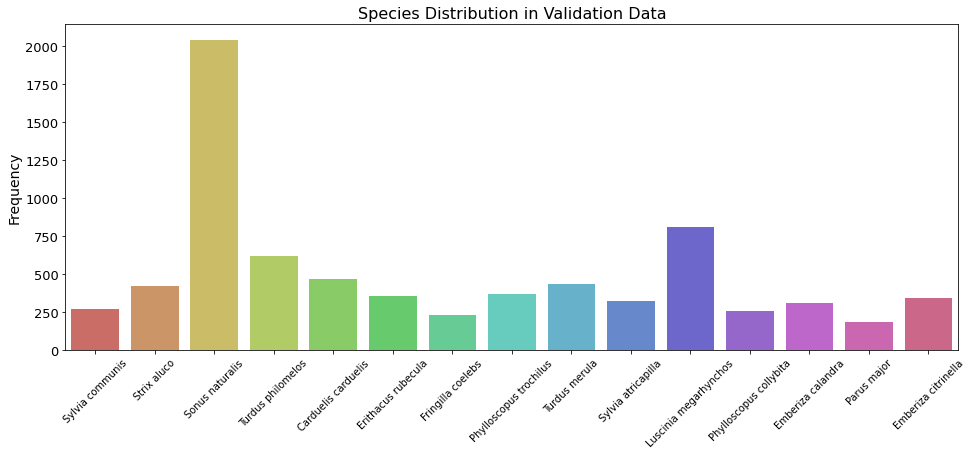

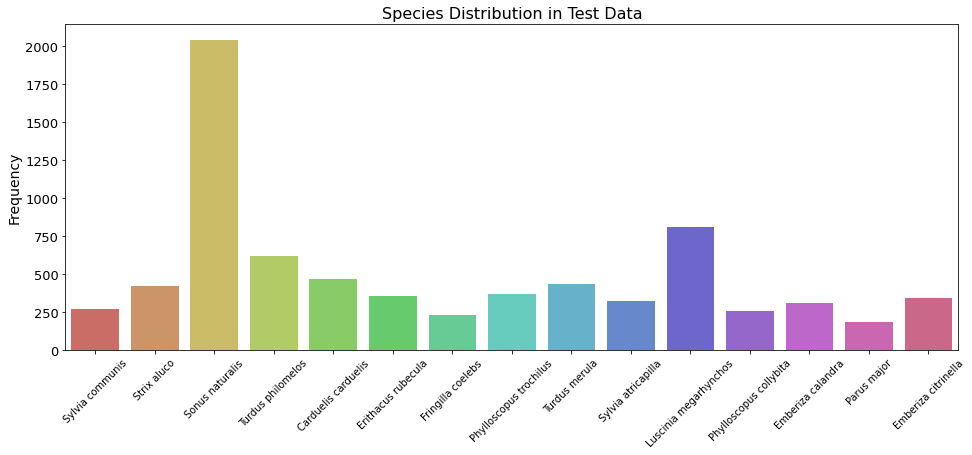

In [ ]:
def plot_species_distribution(dataframe, dataset_title):
  """
  Plots the bird species distribution in a dataset.

  Parameters:
  dataframe: Pandas datafram containing the dataset metadata.
  dataset_title: string defining which dataset is given
  """
  plt.figure(figsize=(16, 6))
  data = dataframe['data_y'].values
  data = [classes[value] for value in data]
  ax = sns.countplot(data, palette="hls") 

  plt.title(f"Species Distribution in {dataset_title}", fontsize=16)
  plt.ylabel("Frequency", fontsize=14)
  plt.yticks(fontsize=13)
  plt.xticks(rotation=45, fontsize=10)
  plt.xlabel("");

# Plot the bird species distribution for all datasets

plot_species_distribution(train_df, 'Training Data')
plot_species_distribution(val_df, 'Validation Data')
plot_species_distribution(test_df, 'Test Data')

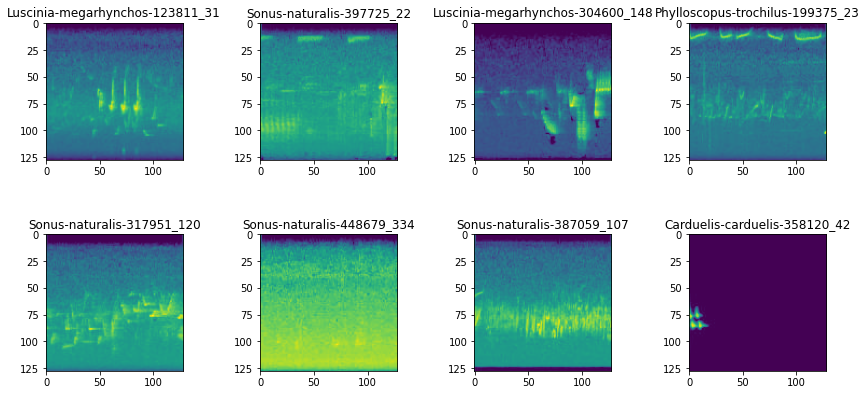

In [ ]:
# Plot some of the generated mel spectorgams 
# code from:
# https://www.kaggle.com/code/mlneo07/birds-spectogram-are-somewhat-cleaned
     
nrows, ncols = 2, 4  
figsize = [12, 6]           


fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

mel_paths = train_df['data_x'].values

for i, axi in enumerate(ax.flat):
    img = Image.open(mel_paths[i])
    file_name = mel_paths[i].split('/')[-1]
    axi.imshow(img)
    axi.set_title(file_name.split('.')[0])


plt.tight_layout(True)
plt.show()

In [ ]:
# zip the melspectogams folder so it can be manually downloaded and reused
# test_data.csv, train_data.csv, and val_data.csv should be manually downloaded
# as well 

!zip -r /content/dataset/melspectograms.zip /content/dataset/melspectograms

Utdata för streaming har trunkerats till de sista 5000 raderna.
  adding: content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-448670_161.jpg (stored 0%)
  adding: content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-477536_68.jpg (stored 0%)
  adding: content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-212969_46.jpg (stored 0%)
  adding: content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-210422_33.jpg (stored 0%)
  adding: content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-155712_53.jpg (stored 0%)
  adding: content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-514130_6.jpg (stored 0%)
  adding: content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-448670_239.jpg (stored 0%)
  adding: content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-155712_26.jpg (stored 0%)
  adding: content/dataset/melspectograms/Erithacus rubecula/Erithacus-rubecula-234111_20.jpg (s